In [35]:
import pandas as pd
import numpy as np
from scipy.signal import find_peaks, peak_prominences

In [36]:
dg_df = pd.read_csv('./big-ideas-lab-glycemic-variability-and-wearable-device-data-1.1.2/Demographics.csv')
dg_df.head(16)

,ID,Gender,HbA1c
0,13,MALE,5.7
1,1,FEMALE,5.5
2,3,FEMALE,5.9
3,4,FEMALE,6.4
4,5,FEMALE,5.7
5,2,MALE,5.6
6,6,FEMALE,5.8
7,7,FEMALE,5.3
8,8,FEMALE,5.6
9,10,FEMALE,6.0


In [37]:
###### ACC
# 가속도 벡터 magnitude 계산 함수
def calculate_mag(acc_x, acc_y, acc_z):
    acc_mag = (acc_x ** 2 + acc_y ** 2 + acc_z ** 2) ** 0.5
    return acc_mag

###### EDA
# rolling window에서 피크를 찾는 함수
def find_peaks_in_rolling_window(data, window_size):
    number_of_windows = 0
    peaks_in_window = 0
    for window_data in data.rolling(window=window_size):
        peaks, _ = find_peaks(window_data[' eda'], height=0, distance=4, prominence=0.3)
        if peaks.any():
            peaks_in_window += len(peaks)
        number_of_windows += 1
    return number_of_windows, peaks_in_window

In [38]:
# 빈 DataFrame 생성
df = pd.DataFrame(columns=[
    'calories2hr',
    'protein2hr',
    'sugar2hr',
    'carbs2hr',
    'calories8hr',
    'protein8hr',
    'sugar8hr',
    'carbs8hr',
    'calories24hr',
    'protein24hr',
    'sugar24hr',
    'carbs24hr',
    'acc_mean',
    'acc_std',
    'acc_min',
    'acc_max',
    'acc_q1g',
    'acc_q3g',
    'acc_skew',
    'eda_mean',
    'eda_std',
    'eda_min',
    'eda_max',
    'eda_q1g',
    'eda_q3g',
    'eda_skew',
    'PeakEDA',
    'PeakEDA2hr_sum',
    'PeakEDA2hr_mean',
    'hr_mean',
    'hr_std',
    'hr_min',
    'hr_max',
    'hr_q1g',
    'hr_q3g',
    'hr_skew',
    'maxHRV',
    'minHRV',
    'medianHRV',
    'meanHRV',
    'SDNN',
    'NN50',
    'pNN50',
    'RMSSD',
    'temp_mean',
    'temp_std',
    'temp_min',
    'temp_max',
    'temp_q1g',
    'temp_q3g',
    'temp_skew'
])

## Warnings

* 003 데이터셋 Food_Log에 칼럼 누락되어 있음 추가 필요 (단, time_end 칼럼은 없어야 하며, 뒷부분의 4개 칼럼은 {calorie,total_carb,sugar,protein}으로 구성됨).
* 001 데이터셋의 HR 대해서 datetime 포맷이 다름 (hr_df['datetime']=pd.to_datetime(hr_df['datetime'], format='%m/%d/%y %H:%M')).
* 012 데이터셋 Food_Log의 마지막 행에 데이터 누락됨.
    ~~~
    2020-05-11,07:00:00,,,Boost,,,,654.0,82.0,5.6,40.0,26.0,26.0
    -> 2020-05-11,07:00:00, 2020-05-11 07:00:00,,Boost,,,,654.0,82.0,5.6,40.0,26.0,26.0
    ~~~
* 013 데이터셋 Food_Log의 date와 datetime 포맷이 다름.
* 중요 : 007 데이터셋의 Food_Log 날짜가 다른 데이터셋들의 측정 날짜와 전혀 일치하지 않음.

In [39]:
def validate_daily_dfs(daily_dfs):
    diff_set = set()
    accset = set()
    edaset = set()
    hrset = set()
    ibiset = set()
    tempset = set()
    dexcomset = set()
    for idx in range(len(daily_dfs['acc'])):
        accset = accset.union(set(date.strftime("%Y-%m-%d") for date in daily_dfs['acc'][idx].index.date))
    for idx in range(len(daily_dfs['eda'])):
        edaset = edaset.union(set(date.strftime("%Y-%m-%d") for date in daily_dfs['eda'][idx].index.date))
    for idx in range(len(daily_dfs['hr'])):
        hrset = hrset.union(set(date.strftime("%Y-%m-%d") for date in daily_dfs['hr'][idx].index.date))
    for idx in range(len(daily_dfs['ibi'])):
        ibiset = ibiset.union(set(date.strftime("%Y-%m-%d") for date in daily_dfs['ibi'][idx].index.date))
    for idx in range(len(daily_dfs['temp'])):
        tempset = tempset.union(set(date.strftime("%Y-%m-%d") for date in daily_dfs['temp'][idx].index.date))
    for idx in range(len(daily_dfs['dexcom'])):
        dexcomset = dexcomset.union(set(date.strftime("%Y-%m-%d") for date in daily_dfs['dexcom'][idx].index.date))
    ## 차집합 연산 : 하나라도 예외적인 다른 날짜가 있다면 제외시켜야 함.
    diff_set = diff_set.union(dexcomset.difference(accset))
    diff_set = diff_set.union(dexcomset.difference(edaset))
    diff_set = diff_set.union(dexcomset.difference(hrset))
    diff_set = diff_set.union(dexcomset.difference(ibiset))
    diff_set = diff_set.union(dexcomset.difference(tempset))
    print(diff_set)

    if len(diff_set) > 0:
        ## diffset의 date값을 갖고 있는 daily_dfs 딕셔너리 내 value 의 리스트 원소(데이터프레임)를 제거
        if len(diff_set & accset) > 0:
            indexes_to_remove = []
            for idx in range(len(daily_dfs['acc'])):
                for date in list(date.strftime("%Y-%m-%d") for date in daily_dfs['acc'][idx].index.date):
                    if date in diff_set:
                        indexes_to_remove.append(idx)
            ## 제거 대상을 제거한 리스트를 새로 할당
            daily_dfs['acc'] = [daily_dfs['acc'][i] for i in range(len(daily_dfs['acc'])) if i not in indexes_to_remove]

        if len(diff_set & edaset) > 0:
            indexes_to_remove = []
            for idx in range(len(daily_dfs['eda'])):
                for date in list(date.strftime("%Y-%m-%d") for date in daily_dfs['eda'][idx].index.date):
                    if date in diff_set:
                        indexes_to_remove.append(idx)
            ## 제거 대상을 제거한 리스트를 새로 할당
            daily_dfs['eda'] = [daily_dfs['eda'][i] for i in range(len(daily_dfs['eda'])) if i not in indexes_to_remove]

        if len(diff_set & hrset) > 0:
            indexes_to_remove = []
            for idx in range(len(daily_dfs['hr'])):
                for date in list(date.strftime("%Y-%m-%d") for date in daily_dfs['hr'][idx].index.date):
                    if date in diff_set:
                        indexes_to_remove.append(idx)
            ## 제거 대상을 제거한 리스트를 새로 할당
            daily_dfs['hr'] = [daily_dfs['hr'][i] for i in range(len(daily_dfs['hr'])) if i not in indexes_to_remove]

        if len(diff_set & ibiset) > 0:
            indexes_to_remove = []
            for idx in range(len(daily_dfs['ibi'])):
                for date in list(date.strftime("%Y-%m-%d") for date in daily_dfs['ibi'][idx].index.date):
                    if date in diff_set:
                        indexes_to_remove.append(idx)
            ## 제거 대상을 제거한 리스트를 새로 할당
            daily_dfs['ibi'] = [daily_dfs['ibi'][i] for i in range(len(daily_dfs['ibi'])) if i not in indexes_to_remove]

        if len(diff_set & tempset) > 0:
            indexes_to_remove = []
            for idx in range(len(daily_dfs['temp'])):
                for date in list(date.strftime("%Y-%m-%d") for date in daily_dfs['temp'][idx].index.date):
                    if date in diff_set:
                        indexes_to_remove.append(idx)
            ## 제거 대상을 제거한 리스트를 새로 할당
            daily_dfs['temp'] = [daily_dfs['temp'][i] for i in range(len(daily_dfs['temp'])) if i not in indexes_to_remove]
        
        if len(diff_set & dexcomset) > 0:
            indexes_to_remove = []
            for idx in range(len(daily_dfs['dexcom'])):
                for date in list(date.strftime("%Y-%m-%d") for date in daily_dfs['dexcom'][idx].index.date):
                    if date in diff_set:
                        indexes_to_remove.append(idx)
            ## 제거 대상을 제거한 리스트를 새로 할당
            daily_dfs['dexcom'] = [daily_dfs['dexcom'][i] for i in range(len(daily_dfs['dexcom'])) if i not in indexes_to_remove]

        return False, daily_dfs
    return True, daily_dfs


# PersHigh, PersLow, PersNorm 분류 함수
def classify_glucose(value, mean, std):
    if value > mean + std:
        return 'PersHigh'
    elif value < mean - std:
        return 'PersLow'
    else:
        return 'PersNorm'

데이터 슬라이싱 코드 수정함.

In [40]:
for id in range(1, len(dg_df)+1):
    if id == 7: # Skip ID 7
        continue
    fl_df = pd.read_csv(f'./big-ideas-lab-glycemic-variability-and-wearable-device-data-1.1.2/{id:03}/Food_Log_{id:03}.csv')
    acc_df = pd.read_csv(f'./big-ideas-lab-glycemic-variability-and-wearable-device-data-1.1.2/{id:03}/ACC_{id:03}.csv')
    eda_df = pd.read_csv(f'./big-ideas-lab-glycemic-variability-and-wearable-device-data-1.1.2/{id:03}/EDA_{id:03}.csv')
    bvp_df = pd.read_csv(f'./big-ideas-lab-glycemic-variability-and-wearable-device-data-1.1.2/{id:03}/BVP_{id:03}.csv')
    hr_df = pd.read_csv(f'./big-ideas-lab-glycemic-variability-and-wearable-device-data-1.1.2/{id:03}/HR_{id:03}.csv')
    ibi_df = pd.read_csv(f'./big-ideas-lab-glycemic-variability-and-wearable-device-data-1.1.2/{id:03}/IBI_{id:03}.csv')
    temp_df = pd.read_csv(f'./big-ideas-lab-glycemic-variability-and-wearable-device-data-1.1.2/{id:03}/TEMP_{id:03}.csv')
    dexcom_df = pd.read_csv(f'./big-ideas-lab-glycemic-variability-and-wearable-device-data-1.1.2/{id:03}/Dexcom_{id:03}.csv')

    biological_sex = dg_df.loc[dg_df['ID'] == id, 'Gender'].values[0]
    hbA1c = dg_df.loc[dg_df['ID'] == id, 'HbA1c'].values[0]

    print(f'ID : {id}')

    ## datetime 변환
    # Dexcom Gluecose
    dexcom_df.drop(dexcom_df.loc[:11].index, inplace=True)
    dexcom_df.rename(columns = {'Timestamp (YYYY-MM-DDThh:mm:ss)': 'datetime'}, inplace = True)
    dexcom_df.rename(columns = {'Glucose Value (mg/dL)': 'glucose'}, inplace = True)
    dexcom_df = dexcom_df[['datetime', 'glucose']]
    dexcom_df['datetime']=pd.to_datetime(dexcom_df['datetime'])
    dexcom_df.set_index('datetime', inplace=True)

    # Food Log
    if id == 13:
        fl_df['time_begin']=pd.to_datetime(fl_df['time_begin'], format='%m/%d/%Y %H:%M')
    else:
        fl_df['time_begin']=pd.to_datetime(fl_df['time_begin'])
    fl_df.index = pd.DatetimeIndex(fl_df["time_begin"])
    fl_df = fl_df.sort_index()
    # Accelerometer
    acc_df['datetime']=pd.to_datetime(acc_df['datetime'])
    acc_resampled = acc_df.set_index('datetime').resample('5Min').first().interpolate(method='time')
    # EDA
    eda_df['datetime']=pd.to_datetime(eda_df['datetime'])
    eda_resampled = eda_df.set_index('datetime').resample('5Min').first().interpolate(method='time')
    # Heart Rate
    if id == 1:
        hr_df['datetime']=pd.to_datetime(hr_df['datetime'], format='%m/%d/%y %H:%M')
    else:
        hr_df['datetime']=pd.to_datetime(hr_df['datetime'])
    hr_resampled = hr_df.set_index('datetime').resample('5Min').first().interpolate(method='time')
    # IBI
    ibi_df['datetime']=pd.to_datetime(ibi_df['datetime'])
    ibi_resampled = ibi_df.set_index('datetime').resample('5Min').first().interpolate(method='time')
    ibi_resampled[' ibi'] = ibi_resampled[' ibi'] * 1000 # 초 -> 밀리초 단위로
    # Temperature
    temp_df['datetime']=pd.to_datetime(temp_df['datetime'])
    temp_resampled = temp_df.set_index('datetime').resample('5Min').first().interpolate(method='time')

    ## 날짜를 기준으로 데이터프레임을 분할하여 리스트에 저장
    daily_dfs = {'fl':[], 'acc':[], 'eda':[], 'hr':[], 'ibi':[], 'temp':[], 'bvp':[], 'dexcom':[]}
    for name, group in dexcom_df.groupby(dexcom_df.index.date):
        daily_dfs['dexcom'].append(group)
    for name, group in fl_df.groupby(fl_df['time_begin'].dt.date):
        daily_dfs['fl'].append(group)
    for name, group in acc_resampled.groupby(acc_resampled.index.date):
        daily_dfs['acc'].append(group)
    for name, group in eda_resampled.groupby(eda_resampled.index.date):
        daily_dfs['eda'].append(group)
    for name, group in hr_resampled.groupby(hr_resampled.index.date):
        daily_dfs['hr'].append(group)
    for name, group in ibi_resampled.groupby(ibi_resampled.index.date):
        daily_dfs['ibi'].append(group)
    for name, group in temp_resampled.groupby(temp_resampled.index.date):
        daily_dfs['temp'].append(group)

    isok, daily_dfs = validate_daily_dfs(daily_dfs=daily_dfs)
    if isok == False:
        print(f'daily_dfs is modified...')
        
    base_df = pd.concat(daily_dfs['dexcom'])
    
    acc_df.drop(acc_df.index, inplace=True)
    eda_df.drop(eda_df.index, inplace=True)
    hr_df.drop(hr_df.index, inplace=True)
    ibi_df.drop(ibi_df.index, inplace=True)
    temp_df.drop(temp_df.index, inplace=True)

    if len(daily_dfs['acc']) > 0:
        acc_df = pd.concat(daily_dfs['acc'])
    if len(daily_dfs['eda']) > 0:
        eda_df = pd.concat(daily_dfs['eda'])
    if len(daily_dfs['hr']) > 0:   
        hr_df = pd.concat(daily_dfs['hr'])
    if len(daily_dfs['ibi']) > 0:
        ibi_df = pd.concat(daily_dfs['ibi'])
    if len(daily_dfs['temp']) > 0:
        temp_df = pd.concat(daily_dfs['temp'])
    
    # 윈도우 크기 설정
    window_size = '24h'

    # 각 타임스탬프에 대해 24시간 롤링 윈도우를 계산
    for timestamp in base_df.index:
        window_start = timestamp - pd.Timedelta(window_size)
        window_end = timestamp 
        
        if window_start < base_df.index[0]:
            continue

        # df_glucose의 롤링 윈도우 범위 내의 데이터 선택
        glucose_window = base_df.loc[window_start:window_end]
        # df_other의 동일한 범위 내의 데이터 선택
        fl_window = fl_df.loc[window_start:window_end]
        acc_window = acc_df.loc[window_start:window_end]
        eda_window = eda_df.loc[window_start:window_end]
        hr_window = hr_df.loc[window_start:window_end]
        ibi_window = ibi_df.loc[window_start:window_end]
        temp_window = temp_df.loc[window_start:window_end]


        ##### fl

        calories2hr = 0.
        protein2hr = 0.
        sugar2hr = 0.
        carbs2hr = 0.
        calories8hr = 0.
        protein8hr = 0.
        sugar8hr = 0.
        carbs8hr = 0.
        calories24hr = 0.
        protein24hr = 0.
        sugar24hr = 0.
        carbs24hr = 0.

        for window_data in fl_window.rolling(window='2h', on='time_begin'):
            calories2hr += window_data['calorie'].values.sum()
            protein2hr += window_data['protein'].values.sum()
            sugar2hr += window_data['sugar'].values.sum()
            carbs2hr += window_data['total_carb'].values.sum()

        for window_data in fl_window.rolling(window='8h', on='time_begin'):
            calories8hr += window_data['calorie'].values.sum()
            protein8hr += window_data['protein'].values.sum()
            sugar8hr += window_data['sugar'].values.sum()
            carbs8hr += window_data['total_carb'].values.sum()

        for window_data in fl_window.rolling(window='24h', on='time_begin'):
            calories24hr += window_data['calorie'].values.sum()
            protein24hr += window_data['protein'].values.sum()
            sugar24hr += window_data['sugar'].values.sum()
            carbs24hr += window_data['total_carb'].values.sum()


        ##### acc
        acc_window = acc_window.copy()
        acc_window['vector_mag'] = calculate_mag(acc_window[' acc_x'], acc_window[' acc_y'], acc_window[' acc_z'])

        acc_mean = acc_window['vector_mag'].mean()
        acc_std = acc_window['vector_mag'].std()
        acc_min = acc_window['vector_mag'].min()
        acc_max = acc_window['vector_mag'].max()
        acc_q1g = acc_window['vector_mag'].quantile(0.25)
        acc_q3g = acc_window['vector_mag'].quantile(0.75)
        acc_skew = acc_window['vector_mag'].skew()


        ###### eda
        eda_mean = eda_window[' eda'].mean()
        eda_std = eda_window[' eda'].std()
        eda_min = eda_window[' eda'].min()
        eda_max = eda_window[' eda'].max()
        eda_q1g = eda_window[' eda'].quantile(0.25)
        eda_q3g = eda_window[' eda'].quantile(0.75)
        eda_skew = eda_window[' eda'].skew()

        # peak detection
        peaks_idx, properties = find_peaks(eda_window[' eda'], height=0, distance=4, prominence=0.3)
        peak_eda = len(peaks_idx)

        number_of_windows, peaks_in_window = find_peaks_in_rolling_window(eda_window, window_size='2h')
        peakEDA2hr_sum = peaks_in_window
        if number_of_windows > 0:
            peakEDA2hr_mean = peaks_in_window / number_of_windows
        else:
            print(f"ID : {id}, timestamp : {timestamp} -> number of 2h eda rolling window == 0")
            peakEDA2hr_mean = np.nan

        ###### hr

        hr_mean = hr_window[' hr'].mean()
        hr_std = hr_window[' hr'].std()
        hr_min = hr_window[' hr'].min()
        hr_max = hr_window[' hr'].max()
        hr_q1g = hr_window[' hr'].quantile(0.25)
        hr_q3g = hr_window[' hr'].quantile(0.75)
        hr_skew = hr_window[' hr'].skew()
        

        ###### ibi

        maxHRV = ibi_window[' ibi'].max()
        minHRV = ibi_window[' ibi'].min()
        medianHRV = ibi_window[' ibi'].median()
        meanHRV = ibi_window[' ibi'].mean()
        sdnn = ibi_window[' ibi'].std()

        nn50 = 0.
        pnn50 = np.nan
        rmssd = np.nan
        if len(ibi_window) > 0:
            for i in range(len(ibi_window)-1):
                if np.abs(ibi_window.iloc[i+1][' ibi'] - ibi_window.iloc[i][' ibi']) > 50:
                    nn50 +=1

            pnn50 = nn50/len(ibi_window)

            rmssd = 0.
            for i in range(len(ibi_window)-1):
                rmssd = np.abs(ibi_window.iloc[i+1][' ibi'] - ibi_window.iloc[i][' ibi'])**2
            rmssd = np.sqrt(rmssd) / len(ibi_window)
        else:
            pnn50 = np.nan
            rmssd = np.nan


        ###### temp

        temp_mean = temp_window[' temp'].mean()
        temp_std = temp_window[' temp'].std()
        temp_min = temp_window[' temp'].min()
        temp_max = temp_window[' temp'].max()
        temp_q1g = temp_window[' temp'].quantile(0.25)
        temp_q3g = temp_window[' temp'].quantile(0.75)
        temp_skew = temp_window[' temp'].skew()


        ##### results
        
        #print(f"(end of window): {window_end}, glucose: {glucose_window['glucose']}, sugar24hr: {sugar24hr}")

        # df_glucose의 개인화된 평균 및 표준 편차 계산 -> Class를 나누는 값 계산
        base_df.loc[window_end, 'personalMean'] = glucose_window['glucose'].mean()
        base_df.loc[window_end, 'personalStd'] = glucose_window['glucose'].std()
        base_df.loc[window_end, 'ID']=id
        base_df.loc[window_end, 'HbA1c']=hbA1c
        base_df.loc[window_end, 'Biological Sex']=biological_sex
        base_df.loc[window_end, 'calories2hr']=calories2hr
        base_df.loc[window_end, 'protein2hr']=protein2hr
        base_df.loc[window_end, 'sugar2hr']=sugar2hr
        base_df.loc[window_end, 'carbs2hr']=carbs2hr
        base_df.loc[window_end, 'calories8hr']=calories8hr
        base_df.loc[window_end, 'protein8hr']=protein8hr
        base_df.loc[window_end, 'sugar8hr']=sugar8hr
        base_df.loc[window_end, 'carbs8hr']=carbs8hr
        base_df.loc[window_end, 'calories24hr']=calories24hr
        base_df.loc[window_end, 'protein24hr']=protein24hr
        base_df.loc[window_end, 'sugar24hr']=sugar24hr
        base_df.loc[window_end, 'carbs24hr']=carbs24hr
        base_df.loc[window_end, 'acc_mean']=acc_mean
        base_df.loc[window_end, 'acc_std']=acc_std
        base_df.loc[window_end, 'acc_min']=acc_min
        base_df.loc[window_end, 'acc_max']=acc_max
        base_df.loc[window_end, 'acc_q1g']=acc_q1g
        base_df.loc[window_end, 'acc_q3g']=acc_q3g
        base_df.loc[window_end, 'acc_skew']=acc_skew
        base_df.loc[window_end, 'eda_mean']=eda_mean
        base_df.loc[window_end, 'eda_std']=eda_std
        base_df.loc[window_end, 'eda_min']=eda_min
        base_df.loc[window_end, 'eda_max']=eda_max
        base_df.loc[window_end, 'eda_q1g']=eda_q1g
        base_df.loc[window_end, 'eda_q3g']=eda_q3g
        base_df.loc[window_end, 'eda_skew']=eda_skew
        base_df.loc[window_end, 'PeakEDA']=peak_eda
        base_df.loc[window_end, 'PeakEDA2hr_sum']=peakEDA2hr_sum
        base_df.loc[window_end, 'PeakEDA2hr_mean']=peakEDA2hr_mean
        base_df.loc[window_end, 'hr_mean']=hr_mean
        base_df.loc[window_end, 'hr_std']=hr_std
        base_df.loc[window_end, 'hr_min']=hr_min
        base_df.loc[window_end, 'hr_max']=hr_max
        base_df.loc[window_end, 'hr_q1g']=hr_q1g
        base_df.loc[window_end, 'hr_q3g']=hr_q3g
        base_df.loc[window_end, 'hr_skew']=hr_skew
        base_df.loc[window_end, 'maxHRV']=maxHRV
        base_df.loc[window_end, 'minHRV']=minHRV
        base_df.loc[window_end, 'medianHRV']=medianHRV
        base_df.loc[window_end, 'meanHRV']=meanHRV
        base_df.loc[window_end, 'SDNN']=sdnn
        base_df.loc[window_end, 'NN50']=nn50
        base_df.loc[window_end, 'pNN50']=pnn50
        base_df.loc[window_end, 'RMSSD']=rmssd
        base_df.loc[window_end, 'temp_mean']=temp_mean
        base_df.loc[window_end, 'temp_std']=temp_std
        base_df.loc[window_end, 'temp_min']=temp_min
        base_df.loc[window_end, 'temp_max']=temp_max
        base_df.loc[window_end, 'temp_q1g']=temp_q1g
        base_df.loc[window_end, 'temp_q3g']=temp_q3g
        base_df.loc[window_end, 'temp_skew']=temp_skew

    # 각 측정값을 PersHigh, PersLow, PersNorm으로 분류
    base_df['label'] = base_df.apply(
        lambda row: classify_glucose(row['glucose'], row['personalMean'], row['personalStd']), axis=1
    )

    base_df.drop(columns=['glucose', 'personalMean', 'personalStd'])

    df = pd.concat([df, base_df], ignore_index=True)
    

ID : 1
set()
ID : 2
set()
ID : 3
set()
ID : 4
set()
ID : 5
set()
ID : 6
set()
ID : 8
set()
ID : 9
set()
ID : 10
set()
ID : 11
set()
ID : 12
set()
ID : 13
set()
ID : 14
{'2020-06-05'}
daily_dfs is modified...
ID : 15
{'2020-07-26', '2020-07-27'}
daily_dfs is modified...
ID : 16
{'2020-07-24'}
daily_dfs is modified...


In [41]:
df = df.dropna().reset_index(drop=True)
df.head(30)

,calories2hr,protein2hr,sugar2hr,carbs2hr,calories8hr,protein8hr,sugar8hr,carbs8hr,calories24hr,protein24hr,...,temp_q1g,temp_q3g,temp_skew,glucose,personalMean,personalStd,ID,HbA1c,Biological Sex,label
0,2693.0,191.9,149.0,189.9,4855.0,270.9,413.0,524.9,9575.0,667.9,...,31.66,35.415,-0.310748,95.0,97.006920,14.146553,1.0,5.5,FEMALE,PersNorm
1,2693.0,191.9,149.0,189.9,4855.0,270.9,413.0,524.9,9575.0,667.9,...,31.66,35.415,-0.320072,95.0,97.131488,13.968094,1.0,5.5,FEMALE,PersNorm
2,2693.0,191.9,149.0,189.9,4855.0,270.9,413.0,524.9,9575.0,667.9,...,31.66,35.415,-0.326616,95.0,97.259516,13.776431,1.0,5.5,FEMALE,PersNorm
3,2693.0,191.9,149.0,189.9,4855.0,270.9,413.0,524.9,9575.0,667.9,...,31.66,35.445,-0.334181,95.0,97.384083,13.590791,1.0,5.5,FEMALE,PersNorm
4,2693.0,191.9,149.0,189.9,4855.0,270.9,413.0,524.9,9575.0,667.9,...,31.66,35.500,-0.340893,92.0,97.484429,13.442287,1.0,5.5,FEMALE,PersNorm
5,2693.0,191.9,149.0,189.9,4855.0,270.9,413.0,524.9,9575.0,667.9,...,31.66,35.535,-0.345253,88.0,97.557093,13.333243,1.0,5.5,FEMALE,PersNorm
6,2693.0,191.9,149.0,189.9,4855.0,270.9,413.0,524.9,9575.0,667.9,...,31.66,35.550,-0.346920,84.0,97.612457,13.243001,1.0,5.5,FEMALE,PersLow
7,2237.0,175.9,66.0,104.9,3487.0,222.9,164.0,269.9,5927.0,539.9,...,31.66,35.550,-0.347584,85.0,97.688581,13.105869,1.0,5.5,FEMALE,PersNorm
8,2237.0,175.9,66.0,104.9,3487.0,222.9,164.0,269.9,5927.0,539.9,...,31.66,35.550,-0.346719,89.0,97.792388,12.915799,1.0,5.5,FEMALE,PersNorm
9,2237.0,175.9,66.0,104.9,3487.0,222.9,164.0,269.9,5927.0,539.9,...,31.66,35.550,-0.343773,93.0,97.906574,12.724986,1.0,5.5,FEMALE,PersNorm


In [42]:
df.to_csv(r'./features.csv', sep='\t', encoding='utf-8', header='true')

In [43]:
df = pd.read_csv(r'./features.csv', sep='\t', encoding='utf-8')

In [44]:
df = df.dropna().drop(columns=['Unnamed: 0']).reset_index(drop=True)

In [45]:
df.isna().sum()

calories2hr        0
protein2hr         0
sugar2hr           0
carbs2hr           0
calories8hr        0
protein8hr         0
sugar8hr           0
carbs8hr           0
calories24hr       0
protein24hr        0
sugar24hr          0
carbs24hr          0
acc_mean           0
acc_std            0
acc_min            0
acc_max            0
acc_q1g            0
acc_q3g            0
acc_skew           0
eda_mean           0
eda_std            0
eda_min            0
eda_max            0
eda_q1g            0
eda_q3g            0
eda_skew           0
PeakEDA            0
PeakEDA2hr_sum     0
PeakEDA2hr_mean    0
hr_mean            0
hr_std             0
hr_min             0
hr_max             0
hr_q1g             0
hr_q3g             0
hr_skew            0
maxHRV             0
minHRV             0
medianHRV          0
meanHRV            0
SDNN               0
NN50               0
pNN50              0
RMSSD              0
temp_mean          0
temp_std           0
temp_min           0
temp_max     

In [46]:
df['Biological Sex'] = df['Biological Sex'].map({'FEMALE': 0, 'MALE': 1})

In [47]:
df['label'] = df['label'].map({'PersLow': 0, 'PersNorm': 1, 'PersHigh':2})

In [48]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.metrics import accuracy_score, mean_squared_error, mean_absolute_percentage_error

def lopocvRFC(df, groupcol, targetcol, dropcols, fs = 0.005):
    logo = LeaveOneGroupOut()
    clf = RandomForestClassifier(n_estimators=100, random_state=0)

    X = df.drop(columns=[targetcol])
    X = X.drop(columns=dropcols)
    y = df[targetcol]
    groups = np.array(df[groupcol])

    importances_df = pd.DataFrame(columns=['value', 'importances', 'id'])

    # RMSE와 MAPE를 저장할 리스트 초기화
    rmse_list = []
    mape_list = []

    for train_index, test_index in logo.split(X, y, groups):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        clf.fit(X_train, y_train.values.ravel())
        y_pred = clf.predict(X_test)
        print(f'Group {groups[test_index][0]} - Accuracy: {accuracy_score(y_test, y_pred)}')

        # RMSE와 MAPE 계산
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        mape = mean_absolute_percentage_error(y_test, y_pred)
        rmse_list.append(rmse)
        mape_list.append(mape)

        feature_list = list(X_train.columns)
    
        # Feature importances를 데이터프레임에 추가
        temp_df = pd.DataFrame({
            'value': [feature_list[i] for i in range(X.shape[1])],
            'importances': clf.feature_importances_,
            'id': groups[test_index][0]  # 테스트 그룹의 ID 추가
        })
        
        importances_df = pd.concat([importances_df, temp_df], ignore_index=True)
    
    # RMSE와 MAPE의 평균 및 표준 편차 계산 및 출력
    mean_rmse = np.mean(rmse_list)
    std_rmse = np.std(rmse_list)
    mean_mape = np.mean(mape_list)
    std_mape = np.std(mape_list)

    print('Mean RMSE:' + str(mean_rmse))
    print('Std RMSE:' + str(std_rmse))
    print('Mean MAPE:' + str(mean_mape))
    print('Std MAPE:' + str(std_mape))

    # 평균 feature importance 계산
    mean_importances = importances_df.groupby('value')['importances'].mean().sort_values(ascending=False).reset_index()

    return mean_rmse, std_rmse, mean_mape, std_mape, mean_importances

In [49]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.metrics import accuracy_score, mean_squared_error, mean_absolute_percentage_error

def lopocvRFR(df, groupcol, targetcol, dropcols, fs = 0.005):
    logo = LeaveOneGroupOut()
    reg = RandomForestRegressor(n_estimators=100, random_state=0)

    X = df.drop(columns=[targetcol])
    X = X.drop(columns=dropcols)
    y = df[targetcol]
    groups = np.array(df[groupcol])

    importances_df = pd.DataFrame(columns=['value', 'importances', 'id'])

    # RMSE와 MAPE를 저장할 리스트 초기화
    rmse_list = []
    mape_list = []

    for train_index, test_index in logo.split(X, y, groups):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        reg.fit(X_train, y_train.values.ravel())
        y_pred = reg.predict(X_test)

        # RMSE와 MAPE 계산
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        mape = mean_absolute_percentage_error(y_test, y_pred)
        rmse_list.append(rmse)
        mape_list.append(mape)

        feature_list = list(X_train.columns)
    
        # Feature importances를 데이터프레임에 추가
        temp_df = pd.DataFrame({
            'value': [feature_list[i] for i in range(X.shape[1])],
            'importances': reg.feature_importances_,
            'id': groups[test_index][0]  # 테스트 그룹의 ID 추가
        })
        
        importances_df = pd.concat([importances_df, temp_df], ignore_index=True)

        print(f'ID : {groups[test_index][0]} ... done')
    
    # RMSE와 MAPE의 평균 및 표준 편차 계산 및 출력
    mean_rmse = np.mean(rmse_list)
    std_rmse = np.std(rmse_list)
    mean_mape = np.mean(mape_list)
    std_mape = np.std(mape_list)

    print('Mean RMSE:' + str(mean_rmse))
    print('Std RMSE:' + str(std_rmse))
    print('Mean MAPE:' + str(mean_mape))
    print('Std MAPE:' + str(std_mape))

    # 평균 feature importance 계산
    mean_importances = importances_df.groupby('value')['importances'].mean().sort_values(ascending=False).reset_index()

    return mean_rmse, std_rmse, mean_mape, std_mape, mean_importances

아래는 RandomForestClassifier로 PersLow, PersNorm, PersHigh 클래스 분류에 대한 중요도를 탐색하기 위한 작업이었으나..  
이렇게 말고 Class-balanced 데이터셋에 대해 계층화된 k-fold cross validation을 반복한 decision tree classifier 모델 구축을 시도하자.  
LOPOCV는 간질 포도당 예측하는 RandomForestRegressor 모델에 적용해보자.

In [50]:
meanrmse, stdrmse, meanmape, stdmape, importances = lopocvRFC(df, 'ID', 'label', ['glucose', 'personalMean', 'personalStd'], fs=0.005)

Group 1.0 - Accuracy: 0.6782570422535211
Group 2.0 - Accuracy: 0.6546448087431694
Group 3.0 - Accuracy: 0.7035749751737835
Group 4.0 - Accuracy: 0.7273212379935966
Group 5.0 - Accuracy: 0.6609347442680776
Group 6.0 - Accuracy: 0.7556684910086005
Group 8.0 - Accuracy: 0.7092293906810035
Group 9.0 - Accuracy: 0.7555775904809122
Group 10.0 - Accuracy: 0.7438105489773951
Group 11.0 - Accuracy: 0.6964355660007834
Group 12.0 - Accuracy: 0.69377990430622
Group 13.0 - Accuracy: 0.7223208999407934
Group 14.0 - Accuracy: 0.7150537634408602
Group 15.0 - Accuracy: 0.7128482972136223
Group 16.0 - Accuracy: 0.726784755770263
Mean RMSE:0.5391090431581195
Std RMSE:0.02867894592024327
Mean MAPE:617484877203301.4
Std MAPE:111507036827488.88


In [51]:
importances.head(15)

,value,importances
0,eda_mean,0.038480
1,temp_skew,0.038316
2,temp_mean,0.037401
3,acc_skew,0.037076
4,eda_std,0.035936
5,eda_skew,0.035701
6,meanHRV,0.035486
7,acc_std,0.035057
8,hr_skew,0.034704
9,hr_std,0.034400


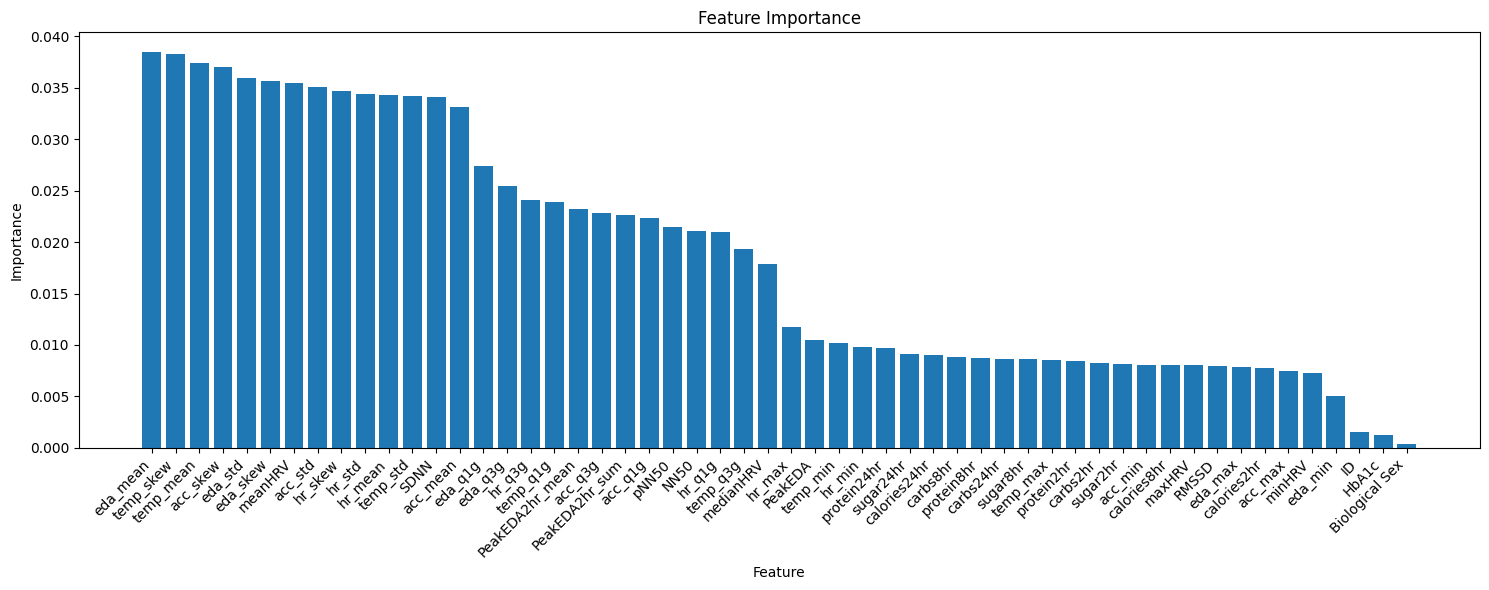

In [52]:
import matplotlib.pyplot as plt

# 막대그래프로 중요도 출력
plt.figure(figsize=(15, 6))
plt.bar(importances['value'], importances['importances'])
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Feature Importance')
plt.xticks(rotation=45, ha='right')  # x축 라벨을 45도로 회전하여 가독성 높임
plt.tight_layout()  # 그래프 간격 조정
plt.show()

### Leave-one-person-out cross validation Random forest regression 모델을 이용한 간질 포도당 예측에 대한 기여도 결정

In [53]:
meanrmse, stdrmse, meanmape, stdmape, importances_reg = lopocvRFR(df, 'ID', 'glucose', ['label', 'personalMean', 'personalStd'], fs=0.005)

ID : 1.0 ... done
ID : 2.0 ... done
ID : 3.0 ... done
ID : 4.0 ... done
ID : 5.0 ... done
ID : 6.0 ... done
ID : 8.0 ... done
ID : 9.0 ... done
ID : 10.0 ... done
ID : 11.0 ... done
ID : 12.0 ... done
ID : 13.0 ... done
ID : 14.0 ... done
ID : 15.0 ... done
ID : 16.0 ... done
Mean RMSE:25.69038748612017
Std RMSE:4.8673877865079715
Mean MAPE:0.17647186649334276
Std MAPE:0.03611228382409567


In [54]:
importances_reg.head(15)

,value,importances
0,acc_skew,0.044545
1,SDNN,0.043660
2,Biological Sex,0.041532
3,eda_mean,0.038805
4,eda_q3g,0.036455
5,acc_std,0.036001
6,eda_skew,0.035641
7,temp_std,0.034576
8,ID,0.033633
9,hr_std,0.032920


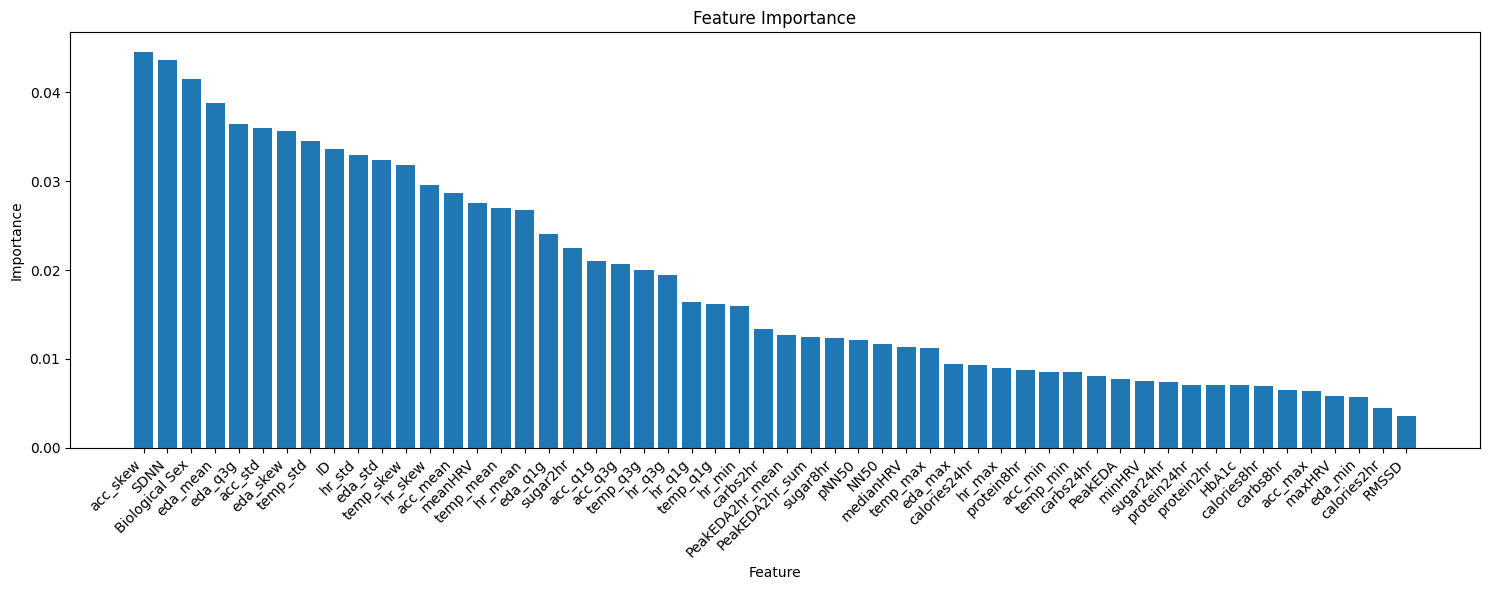

In [55]:
import matplotlib.pyplot as plt

# 막대그래프로 중요도 출력
plt.figure(figsize=(15, 6))
plt.bar(importances_reg['value'], importances_reg['importances'])
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Feature Importance')
plt.xticks(rotation=45, ha='right')  # x축 라벨을 45도로 회전하여 가독성 높임
plt.tight_layout()  # 그래프 간격 조정
plt.show()